# Predicting Linkedin Summary Topic Using LDA

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import re, nltk, spacy

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import bigfloat
bigfloat.exp(5000,bigfloat.precision(100))

BigFloat.exact('2.9676283840236670689662968052896e+2171', precision=100)

In [2]:
dataLinkedin = pd.read_csv('Datasets/datascientist.csv', error_bad_lines=False);

#Remove the first column
del dataLinkedin['Unnamed: 0'];

# We only need the summary text column from the data
linkedinSummary = dataLinkedin[['summary']];

In [3]:
#Remove NaNs
linkedinSummary.dropna(how='any', inplace=True)
linkedinSummary = linkedinSummary.astype('str');

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
#Remove unknown characters

import string
linkedinSummary = linkedinSummary.replace(r'\n',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'►',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'✔',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\t',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\-',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\'',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\"',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\/',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\:',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\•',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\...',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\... ',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\!',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\,',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\.',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\(',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\)',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\|',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\+',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\@',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\_',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\;',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\>',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'\<',' ', regex=True)
linkedinSummary = linkedinSummary.replace(r'I',' ', regex=True)

In [5]:
linkedinSummarytwo = linkedinSummary.summary.values.tolist()
print(linkedinSummarytwo)

['Ambitious  driven  intelligent  steely  efficient  resourceful  critical  savvy  unrelenting Thinker  doer         realist  idealist  willing  able  can do  will do   ', 'Proactive  self motivated  and results driven data scientist who thrives in intellectually challenging positions xcels at establishing positive working relationships with stakeholders and leading technical teams from business concept through deployment of analytical solution ecognized for thought leadership and superior problem solving skills on projects that require creative  interdisciplinary solutions    ', '  have been learning and working in analytics since 2012 here are many reasons why   love this field he main reason is that   like to work on problems that are interesting and not trivial  do not have a specific list of languages and software that must fit with me  just enjoy the opportunity of working on complex data problems and trying to find a solution for them re is a list of data science topics and soft

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

linkedinSum = list(sent_to_words(linkedinSummarytwo))
print(linkedinSum)

[['ambitious', 'driven', 'intelligent', 'steely', 'efficient', 'resourceful', 'critical', 'savvy', 'unrelenting', 'thinker', 'doer', 'realist', 'idealist', 'willing', 'able', 'can', 'do', 'will', 'do'], ['proactive', 'self', 'motivated', 'and', 'results', 'driven', 'data', 'scientist', 'who', 'thrives', 'in', 'intellectually', 'challenging', 'positions', 'xcels', 'at', 'establishing', 'positive', 'working', 'relationships', 'with', 'stakeholders', 'and', 'leading', 'technical', 'teams', 'from', 'business', 'concept', 'through', 'deployment', 'of', 'analytical', 'solution', 'ecognized', 'for', 'thought', 'leadership', 'and', 'superior', 'problem', 'solving', 'skills', 'on', 'projects', 'that', 'require', 'creative', 'solutions'], ['have', 'been', 'learning', 'and', 'working', 'in', 'analytics', 'since', 'here', 'are', 'many', 'reasons', 'why', 'love', 'this', 'field', 'he', 'main', 'reason', 'is', 'that', 'like', 'to', 'work', 'on', 'problems', 'that', 'are', 'interesting', 'and', 'not'

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(linkedinSum, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[linkedinSum], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[linkedinSum[0]]])

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['ambitious', 'driven', 'intelligent', 'steely', 'efficient', 'resourceful', 'critical', 'savvy', 'unrelenting', 'thinker', 'doer', 'realist', 'idealist', 'willing', 'able', 'can', 'do', 'will', 'do']


In [8]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(linkedinSum, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['ambitious drive intelligent steely efficient resourceful critical savvy unrelenting thinker doer realist idealist willing able can do will do', 'proactive self motivated result drive datum scientist who thrive intellectually challenge position xcel establish positive working relationship stakeholder lead technical team business concept deployment analytical solution ecogniz thought leadership superior problem solve skill project that require creative solution']


In [9]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=2,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [10]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.2465007306944615 %


In [11]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=10, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [12]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -145855.16181009184
Perplexity:  812.5126331981345
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 10,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [13]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [14]:
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -55362.92557991706
Model Perplexity:  785.1649908838247


In [28]:
# Compute Perplexity
#print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

NameError: name 'id2word' is not defined

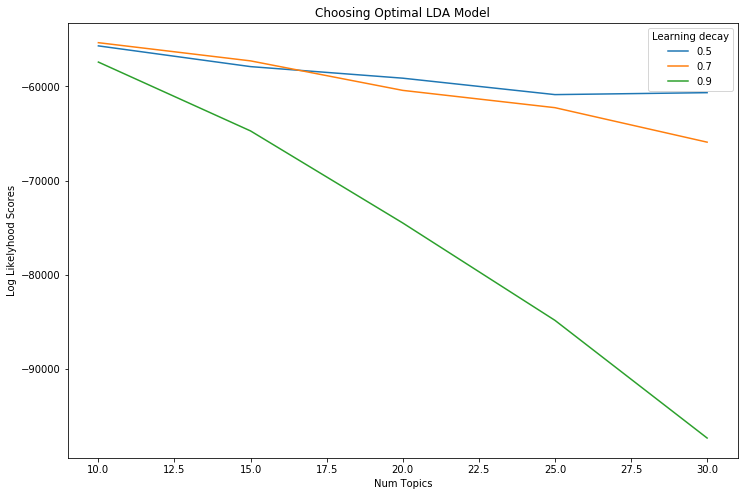

In [16]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [17]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(int(best_lda_model.n_topics))]

# index names
docnames = ["Doc" + str(i) for i in range(len(linkedinSum))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [18]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

NameError: name 'df_document_topic' is not defined

In [19]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics          x          y
topic                                                  
6      68.997192        1       1 -19.077591 -35.151550
8      21.528463        1       2 -57.679123  33.484337
7       2.456402        1       3 -20.697462  35.431149
5       2.005788        1       4 -58.264137  -8.111550
0       1.639421        1       5  43.037937  21.620394
4       1.323772        1       6   8.123004  15.825238
1       0.971551        1       7  19.506689 -19.472889
9       0.471675        1       8 -23.284655   0.643829
3       0.393170        1       9  14.385838  55.722626
2       0.212566        1      10 -27.645741  70.149742, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
392   Default  958.000000          datum  958.000000  30.0000  30.0000
567   Default  327.000000     experience  327.000000  29.0000  29.0000
1779  Default  256.000000           work  256.000000  28.0000  28.0000
1802  Default  151.000000           year  151.000000  27.0000  27.0000
74    Default  281.000000       analysis  281.000000  26.0000  26.0000
1361  Default  103.000000       research  103.000000  25.0000  25.0000
1427  Default  288.000000        science  288.000000  24.0000  24.0000
1429  Default  212.000000      scientist  212.000000  23.0000  23.0000
1751  Default  101.000000  visualization  101.000000  22.0000  22.0000
1226  Default   86.000000     predictive   86.000000  21.0000  21.0000
58    Default   83.000000      algorithm   83.000000  20.0000  20.0000
196   Default  208.000000       business  208.000000  19.0000  19.0000
384   Default  211.000000           data  211.000000  18.0000  18.0000
1250  Default  133.000000        problem  133.000000  17.0000  17.0000
990   Default  159.000000          model  159.000000  16.0000  16.0000
1708  Default   80.000000     university   80.000000  15.0000  15.0000
1489  Default  141.000000          skill  141.000000  14.0000  14.0000
1623  Default   73.000000           team   73.000000  13.0000  13.0000
859   Default  298.000000          learn  298.000000  12.0000  12.0000
844   Default   66.000000      knowledge   66.000000  11.0000  11.0000
305   Default   72.000000       computer   72.000000  10.0000  10.0000
1503  Default   61.000000       solution   61.000000   9.0000   9.0000
470   Default   71.000000          drive   71.000000   8.0000   8.0000
1656  Default   87.000000           time   87.000000   7.0000   7.0000
1558  Default  136.000000    statistical  136.000000   6.0000   6.0000
1504  Default   75.000000          solve   75.000000   5.0000   5.0000
1255  Default   64.000000        product   64.000000   4.0000   4.0000
1626  Default   53.000000      technical   53.000000   3.0000   3.0000
298   Default   48.000000        complex   48.000000   2.0000   2.0000
1287  Default  190.000000         python  190.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
1559  Topic10    0.031770  statistically    4.764158   1.1433  -7.2838
705   Topic10    0.032085       hardware    5.767642   0.9620  -7.2739
1653  Topic10    0.026359     thoughtful    2.321214   1.6756  -7.4705
1067  Topic10    0.027410       notebook    3.240063   1.3812  -7.4314
1289  Topic10    0.027359        pytorch    3.323294   1.3540  -7.4333
261   Topic10    0.030040           code    9.344321   0.4137  -7.3398
132   Topic10    0.025718        awesome    2.060188   1.7703  -7.4951
832   Topic10    0.027918        jupyter    4.837467   0.9988  -7.4131
863   Topic10    0.026667          legal    3.124103   1.3902  -7.4589
1362  Topic10    0.029507     researcher   11.496196   0.1885  -7.3577
256   Topic10    0.025850      cloudtool    2.235152   1.6939  -7.4900
1767  Topic10    0.027752        website    5.486745   0.8669  -7.4190
457   Topic10    0.027505         django    5.065178   0.9379  -7.4280
1702  Topic10    0.

In [20]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

NameError: name 'topicnames' is not defined

In [21]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,datum,swati,puzzle,science,love,create,experiment,time,solution,skill,complex,scientist,technical,collect,earn
Topic 1,field,algorithm,enthusiast,automate,predictive,rutger,certify,consider,explore,vision,understand,engineer,goo,deepgaminga,safety
Topic 2,ossess,deadline,undertake,fast,meet,paced,practical,willing,sense,enthusiast,finish,science,skill,python,hardware
Topic 3,startup,subject,nyc,advice,seed,mentor,linkedin,director,woman,innovate,resource,founder,investment,stage,executive
Topic 4,experience,year,research,analysis,datum,visualization,work,cloud,enterprise,security,knowledge,scientist,data,vmware,causal
Topic 5,work,datum,medium,www,company,free,website,deep,check,research,art,sell,nlp,book,idea
Topic 6,datum,science,machine,experience,work,business,learn,scientist,data,analytic,analysis,learning,problem,year,sql
Topic 7,work,datum,understand,team,model,product,business,delhi,month,analyze,university,internship,award,actively,end
Topic 8,datum,learn,analysis,python,regression,experience,machine,sql,model,hadoop,statistical,spark,network,neural,random
Topic 9,www,https,ggle,colorado,math,free,texas,scholar,love,graphical,foot,store,hire,right,decide


In [22]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Experienced data scientist with a passion for NLP and telling a story"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['datum', 'science', 'machine', 'experience', 'work', 'business', 'learn', 'scientist', 'data', 'analytic', 'analysis', 'learning', 'problem', 'year', 'sql']


In [23]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.01  0.01  0.01  0.01  0.01  0.01  1.    0.01  0.08  0.01]
 [ 0.01  0.    0.    0.    0.    0.01 -0.08  0.01  1.    0.  ]]
Perc of Variance Explained: 
 [0.41 0.35]


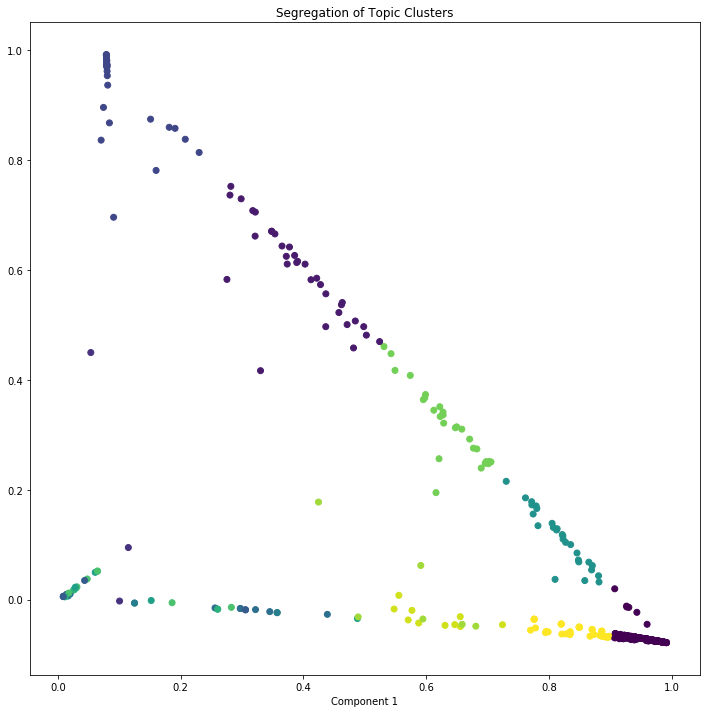

In [24]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [25]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = linkedinSum, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [26]:
# Get similar documents
mytext = ["You will be tasked with helping to transform the way the world integrates data into their decision making while working alongside a brilliant team of curious, data obsessed individuals.  You will work in a data team that ingests, transforms, enriches and connects data from all over the world.  They build the core platforms and tools that allow the company to handle and link this large and varied data, resulting in unique, high-impact products that are opening whole new markets for their clients.  As a Data Scientist, you will work on a variety of extremely challenging problems. You will partner closely with their commercial and engineering teams to identify and tackle important analytical challenges for customers in the Fortune 500 and public sector.  You will be involved in early stage ideation and the development of high-impact analyses and proofs-of-concept as well as develop and validate machine learning models that form a critical part of a large-scale application. In both cases, you will be focused on their data and your analytical skill set to deliver value to end users. Example topics our data scientists have worked on include detecting money laundering at a top-five credit card issuer; defining disaster risk exposure for a top-three insurer or linking drug safety data for a major pharmaceutical company. You will be joining the company at an exciting growth stage when your contributions will impact the entire company and your professional growth will keep pace with your personal drive."]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = linkedinSum, top_n=1, verbose=True)
print('\n', docs[0][:500])

Topic KeyWords:  ['datum', 'science', 'machine', 'experience', 'work', 'business', 'learn', 'scientist', 'data', 'analytic', 'analysis', 'learning', 'problem', 'year', 'sql']
Topic Prob Scores of text:  [[0.  0.  0.  0.  0.  0.  0.9 0.  0.  0. ]]
Most Similar Doc's Probs:   [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]

 ['aim', 'is', 'not', 'to', 'master', 'but', 'to', 'understand', 'hen', 'one', 'ventures', 'to', 'master', 'anything', 'ego', 'chips', 'in', 'owever', 'will', 'to', 'learn', 'opens', 'the', 'door', 'to', 'the', 'treasures', 'of', 'knowledge', 'and', 'pure', 'joy', 'unadulterated', 'by', 'competition', 'jealousy', 'and', 'the', 'rat', 'race', 'ere', 'is', 'nothing', 'insurmountable', 'for', 'anyone', 'who', 'truly', 'puts', 'in', 'the', 'hard', 'work', 'eople', 'will', 'have', 'you', 'believe', 'that', 'something', 'is', 'too', 'hard', 'or', 'you', 'particularly', 'suck', 'at', 'something', 'is', 'not', 'true', 'ou', 'haven', 'developed', 'an', 'interest', 'so', 'far', 'may', 'be', 